# Seasonal climate forecasts for different years

Author: Jatan Buch (v1, 230724) 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools
from copy import deepcopy

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *

#modules for data processing and gradient boosting 
from ngboost import NGBRegressor, distns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, SplineTransformer
from sklearn.metrics import mean_squared_error, r2_score
import pickle # for saving and loading models
from pathlib import Path
import shap

#modules for neural network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions

from datetime import datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

In [2]:
clim_df= pd.read_hdf('../data/clim_12km_1952_2023_data.h5')

In [3]:
input_var_arr= ['Tmax', 'Solar', 'VPD', 'Tmin', 'Prec', 'RH', 'SM_0_100cm', 'PDSI', 'FFWI_max7', 'CAPE']
scaling_flag= 'trend_w_seasonal_cycle' # 'normalized', 'trend' , 'trend_w_seasonal_cycle'
trend_mons= 700 #700 --> 2010; 792 --> 2018
tstart_mon= 0  # 336 --> 1980; 468 --> 1991
tot_months= len(clim_df.month.unique())
if scaling_flag == 'trend_w_seasonal_cycle':
    start_mon= 3
    end_mon= 8

# functionalize the code below
clim_xarr= xarray.Dataset(
            data_vars= dict(
                Tmax= (["time", "Y", "X"], clim_df['Tmax'].values.reshape(tot_months, 208, 155)),
                Solar= (["time", "Y", "X"], clim_df['Solar'].values.reshape(tot_months, 208, 155)),
                VPD= (["time", "Y", "X"], clim_df['VPD'].values.reshape(tot_months, 208, 155)),
                Tmin= (["time", "Y", "X"], clim_df['Tmin'].values.reshape(tot_months, 208, 155)),
                Prec= (["time", "Y", "X"], clim_df['Prec'].values.reshape(tot_months, 208, 155)),
                RH= (["time", "Y", "X"], clim_df['RH'].values.reshape(tot_months, 208, 155)),
                SM_0_100cm= (["time", "Y", "X"], clim_df['SM_0_100cm'].values.reshape(tot_months, 208, 155)),
                PDSI= (["time", "Y", "X"], clim_df['PDSI'].values.reshape(tot_months, 208, 155)),
                FFWI_max7= (["time", "Y", "X"], clim_df['FFWI_max7'].values.reshape(tot_months, 208, 155)),
                CAPE= (["time", "Y", "X"], clim_df['CAPE'].values.reshape(tot_months, 208, 155)),),
            coords=dict(
                X=(["X"], np.linspace(0, 154, 155, dtype= np.int64)),
                Y=(["Y"], np.linspace(0, 207, 208, dtype= np.int64)),
                time= (["time"], pd.date_range(start='1952-01-01', end='2023-05-01', freq='MS')),),) #np.linspace(0, tot_months- 1, tot_months, dtype= np.int64) 

for input_var in input_var_arr:
    if scaling_flag == 'trend':
        result = clim_xarr[input_var][tstart_mon:trend_mons, :, :].polyfit(dim = "time", deg = 1)
        trend= result.polyfit_coefficients.sel(degree= 1).values
        intercept= result.polyfit_coefficients.sel(degree= 0).values
        date_ns_arr= np.array(clim_xarr.time - np.datetime64('1952-01-01'))/np.timedelta64(1, 'ns')

        # multiply trend and intercept with time to get a (857, 208, 155) dimension array
        trend= np.kron(trend[np.newaxis, :, :], date_ns_arr[:, np.newaxis, np.newaxis])
        intercept= np.tile(intercept, (tot_months, 1, 1))
        clim_xarr[input_var + '_trend']= xarray.DataArray(trend + intercept, dims=('time', 'Y', 'X'), coords={'time': clim_xarr.time.values, \
                                                                                                              'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
        detrended_arr= clim_xarr[input_var] - clim_xarr[input_var + '_trend']
        clim_xarr[input_var]= detrended_arr/detrended_arr.std(dim= 'time')
        clim_xarr[input_var + '_std']= xarray.DataArray(np.tile(detrended_arr.std(dim= 'time'), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
    elif scaling_flag == 'trend_w_seasonal_cycle':
        clim_xarr= clim_xarr.sel(time= (clim_xarr.time.dt.month >= start_mon) & (clim_xarr.time.dt.month <= end_mon))
        target_mon_arr= np.arange(start_mon, end_mon + 1, 1)
        ivar_mon_groups= clim_xarr[input_var][tstart_mon:trend_mons, :, :].groupby('time.month')
        tot_mon_groups= clim_xarr[input_var].groupby('time.month')
        trend_arr= []
        intercept_arr= []
        #detrended_std_xarr= []

        for ivar in target_mon_arr: #ivar_mon_groups.groups.keys():
            result= ivar_mon_groups[ivar].polyfit(dim = "time", deg = 1)
            trend_arr.append(result.polyfit_coefficients.sel(degree= 1).values) 
            intercept_arr.append(result.polyfit_coefficients.sel(degree= 0).values)

            date_ns_arr= np.array((tot_mon_groups[target_mon_arr[0]].time - np.datetime64('1952-01-01'))/np.timedelta64(1, 'ns'))
            trend_xarr= xarray.DataArray(data= np.kron(np.array(trend_arr)[0, :, :], date_ns_arr[:, np.newaxis, np.newaxis]), dims= ['time', 'Y', 'X'], \
                                                                                                    coords= dict(time= tot_mon_groups[target_mon_arr[0]].time.values, Y= clim_xarr.Y.values, X= clim_xarr.X.values))
            intercept_xarr= xarray.DataArray(data= np.kron(np.array(intercept_arr)[0, :, :], np.ones((len(tot_mon_groups[target_mon_arr[0]].time), 1, 1))), dims= ['time', 'Y', 'X'], \
                                                                                                    coords= dict(time= tot_mon_groups[target_mon_arr[0]].time.values, Y= clim_xarr.Y.values, X= clim_xarr.X.values))
            #detrended_std_xarr= xarray.DataArray(np.kron((tot_mon_groups[1] - trend_xarr - intercept_xarr).std(dim= 'time'), np.ones((len(tot_mon_groups[1].time), 1, 1))), dims= ['time', 'Y', 'X'], \
            #                                                                                        coords= dict(time= tot_mon_groups[1].time.values, Y= clim_xarr.Y.values, X= clim_xarr.X.values))
                                                                                        
        for i in range(len(target_mon_arr)- 1):
            date_ns_arr= np.array((tot_mon_groups[target_mon_arr[i+1]].time - np.datetime64('1952-01-01'))/np.timedelta64(1, 'ns'))
            tmptrend_xarr= xarray.DataArray(np.kron(np.array(trend_arr)[i, :, :], date_ns_arr[:, np.newaxis, np.newaxis]), dims= ['time', 'Y', 'X'], \
                                                                                    coords= dict(time= tot_mon_groups[target_mon_arr[i+1]].time.values, Y= clim_xarr.Y.values, X= clim_xarr.X.values))
            tmpintercept_xarr= xarray.DataArray(np.kron(np.array(intercept_arr)[i, :, :], np.ones((len(tot_mon_groups[target_mon_arr[i+1]].time), 1, 1))), dims= ['time', 'Y', 'X'], \
                                                                                    coords= dict(time= tot_mon_groups[target_mon_arr[i+1]].time.values, Y= clim_xarr.Y.values, X= clim_xarr.X.values))
            tmpdetrended_std_xarr= xarray.DataArray(np.kron((tot_mon_groups[target_mon_arr[i+1]] - tmptrend_xarr - tmpintercept_xarr).std(dim= 'time'), np.ones((len(tot_mon_groups[target_mon_arr[i+1]].time), 1, 1))), dims= ['time', 'Y', 'X'], \
                                                                                    coords= dict(time= tot_mon_groups[target_mon_arr[i+1]].time.values, Y= clim_xarr.Y.values, X= clim_xarr.X.values))
            trend_xarr= xarray.concat([trend_xarr, tmptrend_xarr], dim= 'time')
            intercept_xarr= xarray.concat([intercept_xarr, tmpintercept_xarr], dim= 'time')
            #detrended_std_xarr= xarray.concat([detrended_std_xarr, tmpdetrended_std_xarr], dim= 'time')

            trend_xarr= trend_xarr.sortby('time')
            intercept_xarr= intercept_xarr.sortby('time')
            #detrended_std_xarr= detrended_std_xarr.sortby('time')

        clim_xarr[input_var + '_trend']= trend_xarr + intercept_xarr
        detrended_std_xarr= (clim_xarr[input_var] - clim_xarr[input_var + '_trend']).std(dim= 'time') 
        clim_xarr[input_var + '_std']= xarray.DataArray(np.tile(detrended_std_xarr, (len(clim_xarr.time.values), 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                   coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
        #detrended_std_xarr= xarray.where(detrended_std_xarr == 0, 0.001, detrended_std_xarr)
        clim_xarr[input_var]= (clim_xarr[input_var] - clim_xarr[input_var + '_trend'])/detrended_std_xarr 
        
    elif scaling_flag == 'normalized':
        clim_xarr[input_var + '_mean']= xarray.DataArray(np.tile(clim_xarr[input_var][:trend_mons, :, :].mean(dim= 'time'), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
        clim_xarr[input_var + '_std']= xarray.DataArray(np.tile(clim_xarr[input_var][:trend_mons, :, :].std(dim= 'time'), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
        clim_xarr[input_var]= (clim_xarr[input_var] - clim_xarr[input_var][:trend_mons, :, :].mean(dim= 'time'))/clim_xarr[input_var][:trend_mons, :, :].std(dim= 'time')
    elif scaling_flag == 'minmax':
        clim_xarr[input_var + '_min']= xarray.DataArray(np.tile(clim_xarr[input_var].min(axis= 0), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
        clim_xarr[input_var + '_max']= xarray.DataArray(np.tile(clim_xarr[input_var].max(axis= 0), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
        clim_xarr[input_var]= (clim_xarr[input_var] - clim_xarr[input_var].min(axis= 0))/(clim_xarr[input_var].max(axis= 0) - clim_xarr[input_var].min(axis= 0))
    elif scaling_flag == 'hybrid':
        if input_var == 'Prec':
            clim_xarr[input_var + '_min']= xarray.DataArray(np.tile(clim_xarr[input_var].min(axis= 0), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
            clim_xarr[input_var + '_max']= xarray.DataArray(np.tile(clim_xarr[input_var].max(axis= 0), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
            clim_xarr[input_var]= (clim_xarr[input_var] - clim_xarr[input_var].min(axis= 0))/(clim_xarr[input_var].max(axis= 0) - clim_xarr[input_var].min(axis= 0))
        else:
            clim_xarr[input_var + '_mean']= xarray.DataArray(np.tile(clim_xarr[input_var][:trend_mons, :, :].mean(dim= 'time'), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
            clim_xarr[input_var + '_std']= xarray.DataArray(np.tile(clim_xarr[input_var][:trend_mons, :, :].std(dim= 'time'), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
            clim_xarr[input_var]= (clim_xarr[input_var] - clim_xarr[input_var][:trend_mons, :, :].mean(dim= 'time'))/clim_xarr[input_var][:trend_mons, :, :].std(dim= 'time')

input_var_arr= np.append([i for i in clim_xarr.data_vars], ['Elev', 'time', 'X', 'Y', 'mei', 'nino34', 'rmm1', 'rmm2']) #'Southness', 
if scaling_flag == 'trend_w_seasonal_cycle':
    totmonarr= np.sort(np.hstack([np.arange(m, 857, 12) for m in range(start_mon - 1, end_mon)]))
    clim_df= pd.concat([clim_xarr.to_dataframe().reset_index(), clim_df[clim_df.month.isin(totmonarr)][['Elev', 'mei', 'nino34', 'rmm1', 'rmm2']].reset_index(drop= True)], axis= 1) #'Southness', 
else:
    clim_df= pd.concat([clim_xarr.to_dataframe().reset_index(), clim_df[['Elev', 'mei', 'nino34', 'rmm1', 'rmm2']]], axis= 1) #'Southness',
clim_df.time= (clim_df.time.dt.year*12 + clim_df.time.dt.month) - (1952*12 + 1) #fix time to be months since 1952-01-01

In [62]:
unit_arr= {'Tmax': 'degC', 'Prec': 'mm' ,'VPD': 'hPa', 'FFWI': 'Intensity', 'Tmin': 'degC'}
cmap_arr= {'Tmax': 'coolwarm', 'Prec': 'BrBG', 'VPD': 'Reds', 'FFWI': 'coolwarm', 'Tmin': 'coolwarm'}
jun_arr= np.arange(5, 855, 12)
jul_arr= jun_arr + 1
aug_arr= jun_arr + 2
sep_arr= jun_arr + 3

In [79]:
### 2023 climate forecasts
target_yr= 2020
target_arr= np.array([857, 858, 859]) - (2023 - target_yr)*12

lead1mons_fcast_arr= target_arr - 1
lead2mons_fcast_arr= target_arr - 2
lead3mons_fcast_arr= target_arr - 3

lead1mons_fcast_df= clim_df[clim_df['time'].isin(lead1mons_fcast_arr)].dropna()[input_var_arr].reset_index().drop(columns= ['index'])
lead2mons_fcast_df= clim_df[clim_df['time'].isin(lead2mons_fcast_arr)].dropna()[input_var_arr].reset_index().drop(columns= ['index'])
lead3mons_fcast_df= clim_df[clim_df['time'].isin(lead3mons_fcast_arr)].dropna()[input_var_arr].reset_index().drop(columns= ['index'])

pred_arr_dynamic= {'Tmax': ['Tmax', 'RH', 'SM_0_100cm', 'PDSI'], 'Prec': ['Prec', 'Tmax', 'RH', 'SM_0_100cm', 'PDSI', 'CAPE'], \
                   'VPD': ['VPD', 'Tmax', 'Prec', 'RH', 'SM_0_100cm', 'PDSI'], 'FFWI': ['FFWI_max7', 'Tmax', 'Prec', 'RH', 'SM_0_100cm', 'PDSI'], \
                    'Tmin': ['Tmin', 'Tmax', 'Prec', 'RH', 'SM_0_100cm', 'PDSI']}

## Prec forecasts

In [80]:
pred_var= 'Prec'  #'VPD', 'Tmax', 'FFWI', 'Tmin'
run_id= 'normalized_lead1mo_seas_detrended' #, 'grid_normalized_lead2mo', 'grid_normalized_lead3mo']
mb_frac= 0.1
n_lead_months= 1

tmax_xr= xarray.open_dataarray('../data/12km/climate/primary/tmax.nc') # for getting the lat/lon coordinates
ind_nan= clim_df.groupby('time').get_group(list(clim_df.groupby('time').groups.keys())[0]).dropna().index
len_xcoord= len(tmax_xr.X)
len_ycoord= len(tmax_xr.Y)
#mon_arr= np.array([854, 855, 856]) - (2023 - target_yr)*12 #add lead month to this

if 'lead1mo' in run_id.split('_'):
    leadmonsdf= lead1mons_fcast_df
    leadsmons_fcast_arr= np.sort(lead1mons_fcast_arr)
elif 'lead2mo' in run_id.split('_'):
    leadmonsdf= lead2mons_fcast_df
    leadsmons_fcast_arr= np.sort(lead2mons_fcast_arr)
elif 'lead3mo' in run_id.split('_'):
    leadmonsdf= lead3mons_fcast_df
    leadsmons_fcast_arr= np.sort(lead3mons_fcast_arr)

In [81]:
for m in tqdm(leadsmons_fcast_arr):    
    ngb_path= 'ngb_%s'%pred_var + '_%s'%run_id + '_mb_%.2f.p'%(mb_frac)
    file_path = Path.home()/'Desktop/seasonal_fire_pred/sav_files/ngb_mods'/ngb_path
    with file_path.open("rb") as f:
        ngb= pickle.load(f)

    Y_dist_loc= []
    Y_dist_scale= []
    # Y_obs= []

    #m= 856 - (2023 - target_yr)*12
    leadmonsdf_groups= leadmonsdf.groupby(['time'], as_index= False)
    X_test= leadmonsdf_groups.get_group(m)[input_var_arr]
    Y_test_std= clim_df.dropna().groupby('time').get_group(m - (12 - n_lead_months))[pred_var + '_std'] # consider std and trend values of the same month in the previous year
    Y_test_mean= clim_df.dropna().groupby('time').get_group(m - (12 - n_lead_months))[pred_var + '_trend']# ensure that Y is always the target variable and not a predictor

    X_test_scaled= pd.concat([X_test[pred_arr_dynamic[pred_var]], X_test[['Elev', 'nino34', 'mei', 'rmm1', 'rmm2']]], axis= 1).replace(np.nan, 0)
    poly = PolynomialFeatures(1)
    X_test_poly= poly.fit_transform(X_test_scaled)
        
    tmplocarr= np.ones(len_xcoord*len_ycoord)*np.nan
    tmpsigarr= np.ones(len_xcoord*len_ycoord)*np.nan
    tmplocarr[ind_nan]= ngb.pred_dist(X_test_poly).params['loc']*Y_test_std + Y_test_mean
    tmpsigarr[ind_nan]= ngb.pred_dist(X_test_poly).params['scale']*Y_test_std
    Y_dist_loc.append(tmplocarr)
    Y_dist_scale.append(tmpsigarr)

    Y_dist_loc_xr= xarray.DataArray(np.array(Y_dist_loc).reshape(len_ycoord, len_xcoord), \
                                            coords= {'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['Y', 'X'])
    Y_dist_scale_xr= xarray.DataArray(np.array(Y_dist_scale).reshape(len_ycoord, len_xcoord), \
                                            coords= {'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['Y', 'X'])
    Y_dist_loc_xr.to_netcdf('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s'%m + '_%d_ngb_loc.nc'%target_yr) #run_id
    Y_dist_scale_xr.to_netcdf('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s'%m + '_%d_ngb_scale.nc'%target_yr)

100%|██████████| 3/3 [00:19<00:00,  6.62s/it]


In [82]:
xarr_tmax_2023= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s'%leadsmons_fcast_arr[0] + '_%d_ngb_loc.nc'%target_yr) #run_id_arr[0]
for i in range(len(leadsmons_fcast_arr)-1): #run_id_arr
    xarr_tmax_2023= xarray.concat([xarr_tmax_2023, xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s'%leadsmons_fcast_arr[i+1] + '_%d_ngb_loc.nc'%target_yr)], dim= 'time')

Y_obs_xr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_obs.nc')

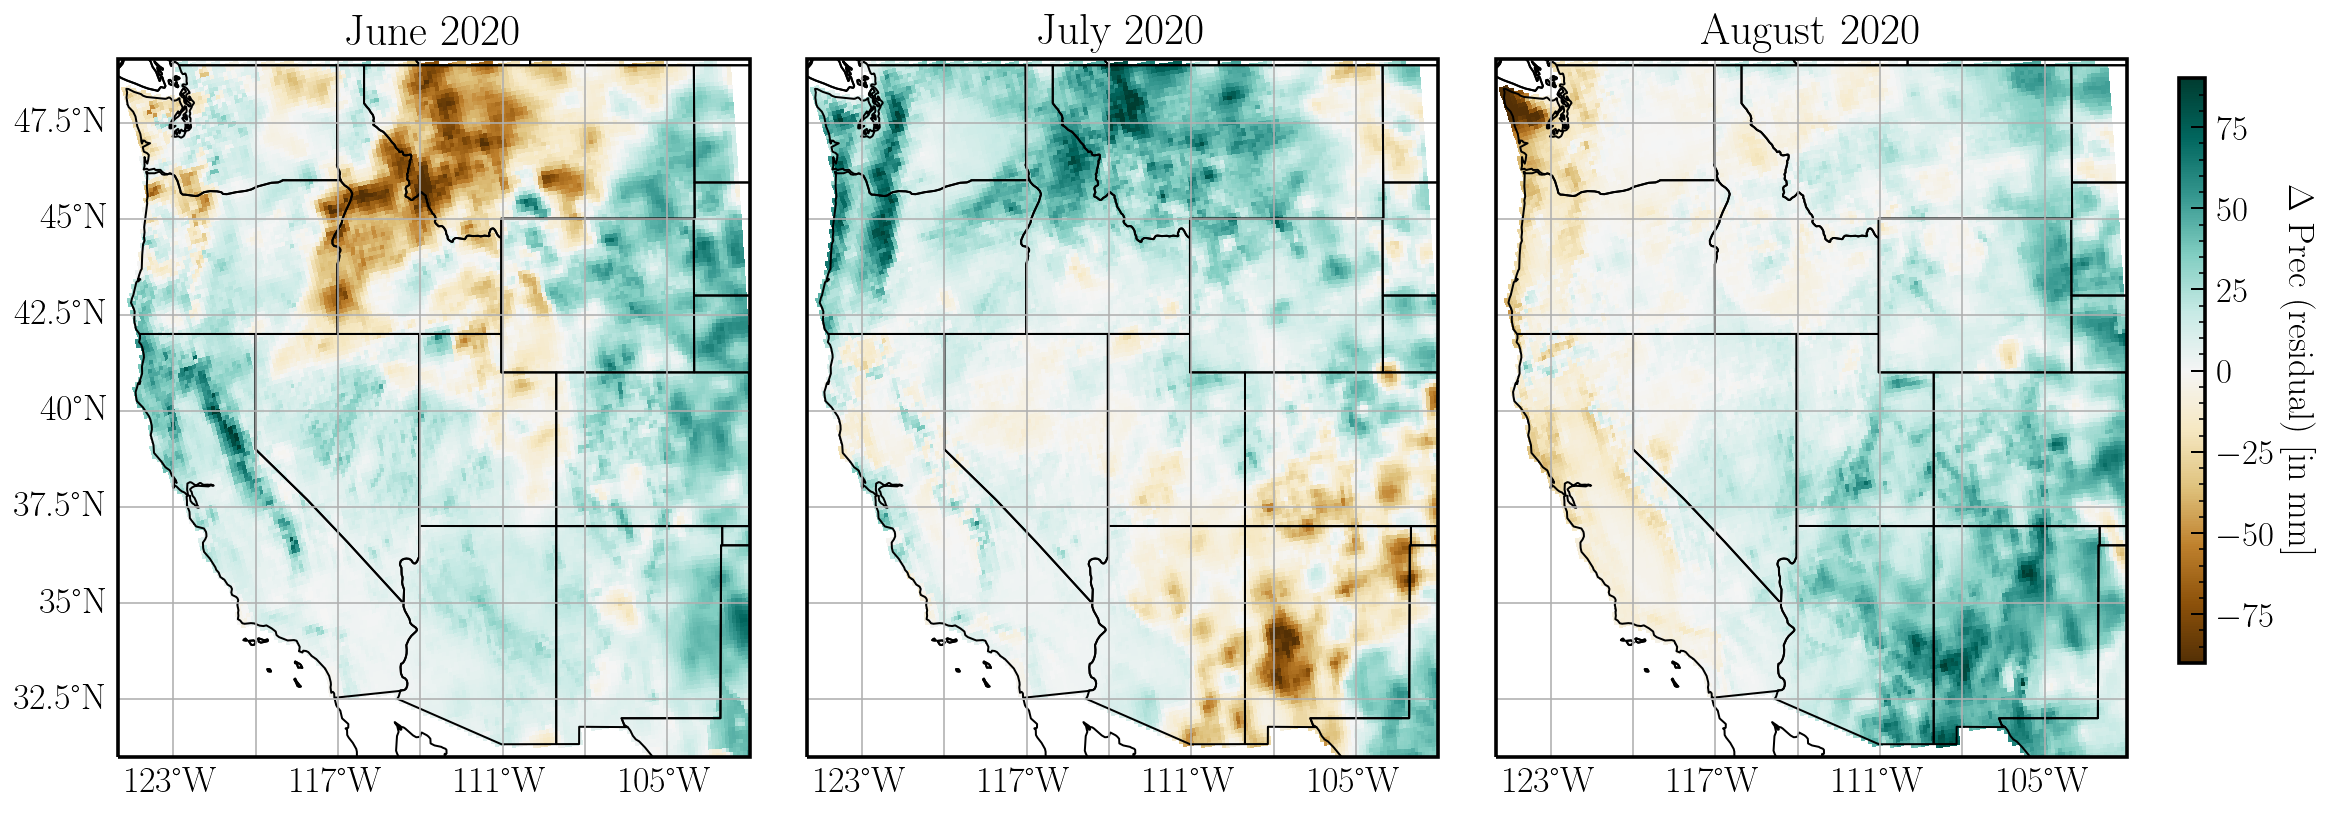

In [83]:
lat_long_fire_grid= coord_transform(xarr_tmax_2023['X'][:].data, xarr_tmax_2023['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
plot_id= 'normalized_seas_detrended'
vmin_pred= -90
vmax_pred= 90

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(4, 6)

ax= fig.add_subplot(gs[0:4, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');
CS= ax.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], xarr_tmax_2023[0, : , :] - Y_obs_xr.sel(time= (target_yr - 1952)*12 + 5).values, vmin= vmin_pred, vmax= vmax_pred, cmap= cmap_arr[pred_var]) #.mean(axis= 0, skipna= False)
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1)
ax.set_title(r'June %d'%target_yr, fontsize= 22);

ax1= fig.add_subplot(gs[0:4, 2:4], projection=ccrs.PlateCarree())
ax1.set_extent(extent);
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black');
CS1= ax1.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], xarr_tmax_2023[1, : , :] - Y_obs_xr.sel(time= (target_yr - 1952)*12 + 6).values, vmin= vmin_pred, vmax= vmax_pred, cmap= cmap_arr[pred_var]) #.mean(axis= 0, skipna= False)
gl1= ax1.gridlines(draw_labels=True);
gl1.xlabel_style = {'size': 18, 'color': 'black'}
gl1.ylabel_style = {'size': 18, 'color': 'black'}
gl1.top_labels = False
gl1.left_labels = False
gl1.right_labels = False
ax1.set_aspect(1.4/1)
ax1.set_title(r'July %d'%target_yr, fontsize= 22);

ax2= fig.add_subplot(gs[0:4, 4:6], projection=ccrs.PlateCarree())
ax2.set_extent(extent);
ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax2.add_feature(cfeature.STATES, edgecolor='black');
CS2= ax2.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], xarr_tmax_2023[2, : , :] - Y_obs_xr.sel(time= (target_yr - 1952)*12 + 7).values, vmin= vmin_pred, vmax= vmax_pred, cmap= cmap_arr[pred_var]) #.mean(axis= 0, skipna= False)
cax1= fig.add_axes([ax2.get_position().x1 + 0.02, ax2.get_position().y1 - 0.35, 0.01, ax2.get_position().height + 0.06])
cbar1= fig.colorbar(CS2, cax= cax1, orientation= 'vertical')
cbar1.set_label(r'$\Delta$ %s (residual) '%pred_var + '[in  %s]'%unit_arr[pred_var], labelpad= 20, rotation= 270, fontsize= 18)
gl2= ax2.gridlines(draw_labels=True);
gl2.xlabel_style = {'size': 18, 'color': 'black'}
gl2.ylabel_style = {'size': 18, 'color': 'black'}
gl2.top_labels = False
gl2.left_labels = False
gl2.right_labels = False
ax2.set_aspect(1.4/1)
ax2.set_title(r'August %d'%target_yr, fontsize= 22);

#cax= fig.add_axes([ax.get_position().x1, ax.get_position().y0 - 0.1, ax.get_position().width + 0.04, 0.02])
#cbar= fig.colorbar(CS, cax= cax, orientation= 'horizontal')
#cbar.set_label(r'Tmax [in degC]', labelpad= 20, fontsize= 18)

plt.savefig('../plots/seasonal_preds/%s'%pred_var + '_jja_lead1mo_%d'%target_yr + '_%s.pdf'%plot_id, bbox_inches='tight', dpi= 300);

## Tmax forecasts

In [ ]:
lat_long_fire_grid= coord_transform(xarr_tmax_2023['X'][:].data, xarr_tmax_2023['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
plot_id= 'normalized_seas_detrended'
vmin_pred= -70
vmax_pred= 70

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(4, 6)

ax= fig.add_subplot(gs[0:4, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');
CS= ax.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], xarr_tmax_2023[0, : , :] - np.mean(Y_obs_xr[Y_obs_xr.time.isin(jun_arr[28:59]), :, :], axis= 0), vmin= vmin_pred, vmax= vmax_pred, cmap=plt.cm.coolwarm) #.mean(axis= 0, skipna= False)
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1)
ax.set_title(r'June %d'%target_yr, fontsize= 22);

ax1= fig.add_subplot(gs[0:4, 2:4], projection=ccrs.PlateCarree())
ax1.set_extent(extent);
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black');
CS1= ax1.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], xarr_tmax_2023[1, : , :] - np.mean(Y_obs_xr[Y_obs_xr.time.isin(jul_arr[28:59]), :, :], axis= 0), vmin= vmin_pred, vmax= vmax_pred, cmap=plt.cm.coolwarm) #.mean(axis= 0, skipna= False)
gl1= ax1.gridlines(draw_labels=True);
gl1.xlabel_style = {'size': 18, 'color': 'black'}
gl1.ylabel_style = {'size': 18, 'color': 'black'}
gl1.top_labels = False
gl1.left_labels = False
gl1.right_labels = False
ax1.set_aspect(1.4/1)
ax1.set_title(r'July %d'%target_yr, fontsize= 22);

ax2= fig.add_subplot(gs[0:4, 4:6], projection=ccrs.PlateCarree())
ax2.set_extent(extent);
ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax2.add_feature(cfeature.STATES, edgecolor='black');
CS2= ax2.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], xarr_tmax_2023[2, : , :] - np.mean(Y_obs_xr[Y_obs_xr.time.isin(aug_arr[28:59]), :, :], axis= 0), vmin= vmin_pred, vmax= vmax_pred, cmap=plt.cm.coolwarm) #.mean(axis= 0, skipna= False)
cax1= fig.add_axes([ax2.get_position().x1 + 0.02, ax2.get_position().y1 - 0.35, 0.01, ax2.get_position().height + 0.06])
cbar1= fig.colorbar(CS2, cax= cax1, orientation= 'vertical')
cbar1.set_label(r'$\Delta$ %s (1980-2018 climatology)'%pred_var + '[in  %s]'%unit_arr[pred_var], labelpad= 20, rotation= 270, fontsize= 18)
gl2= ax2.gridlines(draw_labels=True);
gl2.xlabel_style = {'size': 18, 'color': 'black'}
gl2.ylabel_style = {'size': 18, 'color': 'black'}
gl2.top_labels = False
gl2.left_labels = False
gl2.right_labels = False
ax2.set_aspect(1.4/1)
ax2.set_title(r'August %d'%target_yr, fontsize= 22);

#cax= fig.add_axes([ax.get_position().x1, ax.get_position().y0 - 0.1, ax.get_position().width + 0.04, 0.02])
#cbar= fig.colorbar(CS, cax= cax, orientation= 'horizontal')
#cbar.set_label(r'Tmax [in degC]', labelpad= 20, fontsize= 18)

plt.savefig('../plots/seasonal_preds/%s'%pred_var + '_jja_lead1mo_%d'%target_yr + '_%s.pdf'%plot_id, bbox_inches='tight', dpi= 300);